In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from skimage.feature import graycomatrix

import os
os.chdir("../")
from Sources.tools import *

# Load Data

In [2]:
preprocess_images = np.load("Data/images_without_label.npy", allow_pickle=True)

In [3]:
images_region_of_interest = get_region_of_interest(preprocess_images)

Removing Pectoral Muscle:   0%|          | 0/322 [00:00<?, ?it/s]c:\Users\planc\anaconda3\envs\env_ovo_project\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\planc\anaconda3\envs\env_ovo_project\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\planc\anaconda3\envs\env_ovo_project\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\planc\anaconda3\envs\env_ovo_project\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\planc\anaconda3\envs\env_ovo_pr

# Apply GLCM

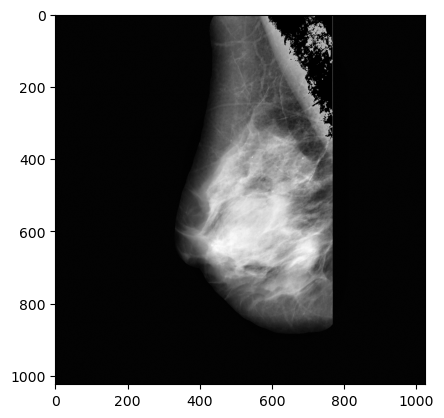

In [89]:
image = images_region_of_interest[0]

plt.imshow(image, cmap="grey")
plt.show()

In [90]:
glcm = graycomatrix(image, distances=[1], angles=[0., 0.78539816, 1.57079633, 2.35619449], levels=256, symmetric=True, normed=False)

In [13]:
glcm.shape

(256, 256, 1, 4)

In [95]:
def compute_features_glcm(glcm, angles_nb:int=4) -> list:
    """Compute GLCM features (Autocorrelation, contrast, cluster prominence, entopy).

    Returns:
        list: Average feature for all angles computed in GLCM
    """
    autocorrelations = []
    contrasts = []
    cluster_prominences = []
    entropies = []

    for angle in range(angles_nb):

        # Extraction de la matrice GLCM normalisée
        P = glcm[:, :, 0, angle]  # Prend la matrice pour l'angle donné

        # Indices des niveaux de gris
        i, j = np.indices(P.shape)

        # Calcul des features
        autocorrelation = np.sum(i * j * P)
        contrast = np.sum(P * (i - j) ** 2)
        mean = np.sum(i * P)  # Moyenne des intensités
        cluster_prominence = np.sum((i + j - 2 * mean) ** 4 * P)
        entropy = -np.sum(P * np.log2(P + 1e-10))  # Ajout de 1e-10 pour éviter log(0)

        autocorrelations += [autocorrelation]
        contrasts += [contrast]
        cluster_prominences += [cluster_prominence]
        entropies += [entropy]

    avg_autocorrelation = np.mean(autocorrelations)
    avg_contrast = np.mean(contrasts)
    avg_cluster_prominence = np.mean(cluster_prominences)
    avg_entropy = np.mean(entropies)

    return [avg_autocorrelation, avg_contrast, avg_cluster_prominence, avg_entropy]

In [92]:
avg_autocorrelation, avg_contrast, avg_cluster_prominence, avg_entropy = compute_features_glcm(glcm)

# GLRLM

In [94]:
def compute_glrlm(image, max_gray_level, angles=[0, 45, 90, 135]):

    def get_runs(img, angle):
        if angle == 0:  # horizontal
            lines = img
        elif angle == 90:  # vertical
            lines = img.T  
        elif angle == 45: 
            lines = [np.diag(img, k) for k in range(-img.shape[0]+1, img.shape[1])]
        elif angle == 135: 
            flipped_img = np.fliplr(img) 
            lines = [np.diag(flipped_img, k) for k in range(-flipped_img.shape[0]+1, flipped_img.shape[1])]

        runs = []
        for line in lines:
            if len(line) == 0:
                continue
            run_length = 1
            for i in range(1, len(line)):
                if line[i] == line[i - 1]:
                    run_length += 1
                else:
                    runs.append((line[i - 1], run_length))
                    run_length = 1
            runs.append((line[-1], run_length))  # last run
        return runs

    # Initialisation GLRLMs
    glrlms = {angle: np.zeros((max_gray_level, image.shape[1]), dtype=int) for angle in angles}

    # Compute fo each angle
    for angle in angles:
        runs = get_runs(image, angle)
        for gray_level, run_length in runs:
            if run_length <= image.shape[1]:
                glrlms[angle][gray_level, run_length - 1] += 1

    return glrlms

In [17]:
glrlm = compute_glrlm(image, max_gray_level=256, angles=[0, 45, 90, 135])

In [33]:
glrlm[0].shape

(256, 1024)

In [93]:
def compute_features_glrlm(glrlm, angles:list=[0,45,90,135]) -> list:
    """Compute GLRLM features (Short run emphasis, Long run emphasis, Gray-level non-uniformity, Short run low gray-levvel emphasis, Logn run low gray_level emphasis).

    Returns:
        list: Average feature for all angles computed in GLRLM
    """
    all_SRE = []
    all_LRE = []
    all_GLNU = []
    all_SRLGE = []
    all_LRLGE = []

    for angle in angles:

        # Extraction de la matrice GLRLM
        P = glrlm[angle]  # Prend la matrice pour l'angle donné

        G, R = P.shape # G niveaux de gris, R longueurs des runs

        # Somme totale des valeurs dans la matrice GLRLM
        total = np.sum(P)

        # Indices des niveaux de gris et longueurs des runs
        runs = np.arange(1, R + 1)  # Longueurs de runs (1,2,3,...)
        gray_levels = np.arange(1, G + 1)  # Niveaux de gris (1,2,3,...)

        # Somme des valeurs sur les longueurs des runs et niveaux de gris
        sum_over_runs = np.sum(P, axis=1)  # Somme pour chaque niveau de gris
        sum_over_gray = np.sum(P, axis=0)  # Somme pour chaque longueur de run

        # Calcul des features
        SRE = np.sum(sum_over_gray / (runs ** 2)) / total  # Short Run Emphasis
        LRE = np.sum(sum_over_gray * (runs ** 2)) / total  # Long Run Emphasis
        GLNU = np.sum(sum_over_runs ** 2) / total  # Gray-Level Non-Uniformity
        SRLGE = np.sum(P.T / ((runs[:, None] ** 2) * (gray_levels[None, :] ** 2))) / total  # Short Run Low Gray-Level Emphasis
        LRLGE = np.sum(P.T * (runs[:, None] ** 2) / (gray_levels[None, :]**2)) / total  # Long Run Low Gray-Level Emphasis

        all_SRE += [SRE]
        all_LRE += [LRE]
        all_GLNU += [GLNU]
        all_SRLGE += [SRLGE]
        all_LRLGE += [LRLGE]

    avg_SRE = np.mean(all_SRE)
    avg_LRE = np.mean(all_LRE)
    avg_GLNU = np.mean(all_GLNU)
    avg_SRLGE = np.mean(all_SRLGE)
    avg_LRLGE = np.mean(all_LRLGE)

    return [avg_SRE, avg_LRE, avg_GLNU, avg_SRLGE, avg_LRLGE]

In [81]:
avg_SRE, avg_LRE, avg_GLNU, avg_SRLGE, avg_LRLGE = compute_features_glrlm(glrlm)

# Compute features for all images

In [98]:
def get_features_from_images(image_roi):
    autocorrelation = []
    contrast = []
    cluster_prominence = []
    entropy = []

    SRE = []
    LRE = []
    GLNU = []
    SRLGE = []
    LRLGE = []

    for image in tqdm(image_roi, desc="Extracting features ..."):
        # GLCM
        glcm = graycomatrix(image, distances=[1], angles=[0., 0.78539816, 1.57079633, 2.35619449], levels=256, symmetric=True, normed=False)
        avg_autocorrelation, avg_contrast, avg_cluster_prominence, avg_entropy = compute_features_glcm(glcm)

        autocorrelation += [avg_autocorrelation]
        contrast += [avg_contrast]
        cluster_prominence += [avg_cluster_prominence]
        entropy += [avg_entropy]

        # GLRLM
        glrlm = compute_glrlm(image, max_gray_level=256, angles=[0, 45, 90, 135])
        avg_SRE, avg_LRE, avg_GLNU, avg_SRLGE, avg_LRLGE = compute_features_glrlm(glrlm)

        SRE += [avg_SRE]
        LRE += [avg_LRE]
        GLNU += [avg_GLNU]
        SRLGE += [avg_SRLGE]
        LRLGE += [avg_LRLGE]

    data = pd.DataFrame({"autocorrelation":autocorrelation, "contrast":contrast, "cluster_prominence":cluster_prominence, "entropy":entropy, "SRE":SRE, "LRE":LRE, "GLNU":GLNU, "SRLGE":SRLGE, "LRLGE":LRLGE})

    return data

In [99]:
data = get_features_from_images(images_region_of_interest)

Extracting features ...: 100%|██████████| 322/322 [04:58<00:00,  1.08it/s]


In [100]:
data.to_csv("Data/exctracted_features.csv", index=False, sep=";")

In [102]:
data

,autocorrelation,contrast,cluster_prominence,entropy,SRE,LRE,GLNU,SRLGE,LRLGE
0,1.028521e+10,267961182.5,4.075990e+18,-3.431037e+07,0.887978,1346.791926,1337.502577,0.002697,88.638423
1,1.307181e+10,299677314.0,2.310802e+17,-3.284055e+07,0.890659,1043.472663,1487.615693,0.002960,72.562531
2,1.408697e+10,141461972.5,-2.568155e+18,-3.400099e+07,0.884898,1274.675058,1311.839759,0.001111,91.096158
3,1.646584e+10,174817302.5,1.638073e+18,-3.286891e+07,0.885616,1017.705164,1558.575770,0.001367,77.164984
4,1.702260e+10,653435364.0,-2.867736e+18,-2.994633e+07,0.883225,486.280806,3998.275202,0.004939,35.250638
...,...,...,...,...,...,...,...,...,...
317,9.288857e+09,366829325.5,-3.380557e+18,-3.752381e+07,0.850045,2684.590810,1218.974026,0.006298,197.007678
318,1.940154e+10,241357228.0,1.703209e+18,-2.971711e+07,0.886490,508.585693,2905.293449,0.001408,44.975496
319,2.011510e+10,234472309.0,-7.601223e+17,-3.023807e+07,0.875200,573.292162,1985.401396,0.001437,73.324482
320,1.594847e+10,498173520.5,-1.379895e+18,-3.271282e+07,0.870303,913.247552,2113.820319,0.005579,62.735151
